In [10]:
import os
import threading
import time

import sys
sys.path.insert(0, "../")

import matplotlib.pyplot as plt

import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

import torch
from torch.optim import Adam

from utils.kfp import get_B_block, diffusion_coeff, solve_pde, logsumexp, get_sparse_A_block
from network.network import ScoreNet

from data.Dataset import CIFARDataset

torch.manual_seed(2);

mm_scaler = MinMaxScaler();

## Parameters

In [11]:
### Change these
N = 10
H = 28
W = 28
epochs = 3
eps = 1e-6
sigma = 25
###

eps = 1e-6
dt = 1/N

## Instantiate Dataset

In [12]:
dataset = CIFARDataset(W, H);

channels = dataset.channels
n_data = len(dataset)

Files already downloaded and verified


## Create Model

In [13]:
model_score = ScoreNet(H=H, W=W, in_channels=channels)
loss_fn = torch.nn.MSELoss()
optimizer = Adam(model_score.parameters(), lr=1e-3)

model_score.train();

## Create memory buffers


In [14]:
scores = np.zeros((N, channels, H, W), dtype=np.float32)
kdes = np.full((n_data, channels), None)

params = {"bandwidth": np.logspace(-1, 1, 20)}

## Diffuse Function for 1 channel

In [15]:
def get_init_score(data, data_idx, channel):
  if not kdes[data_idx, channel]:
      grid = GridSearchCV(KernelDensity(), params)
      kdes[data_idx, channel] = grid.fit(data.ravel()[:, None]) # 0.7 sec
  return kdes[data_idx, channel].score_samples(data.ravel()[:, None])
  
def construct_samples(random_t, del_m, m, sigma_, train_x_data, train_y_data, channel):
  # constructing the training data and labels
  for i, _ in enumerate(random_t, 1):
    del_m[channel][i] = np.diff(m[channel][i].ravel(), axis=0, prepend=m[channel][i, 0])

  x = torch.tensor(mm_scaler.fit_transform(np.exp((-m[channel].ravel() - logsumexp(-m[channel].ravel())))[:, None])).reshape((N, 1, H, W))
  perturbed_x = x + torch.randn_like(x) * torch.sqrt(2 * torch.tensor(sigma_)**2)[:, None, None, None]
  train_x_data[:, channel] = perturbed_x[:, 0]
  train_y_data[:, channel] = torch.tensor(del_m[channel].astype(np.float32)).reshape((N, H, W))


In [16]:
def diffuse(data, x, m , del_m, channel, train_x_data, train_y_data, random_t, time_, sigma_, data_idx):
    data = data[channel]
    dx = data.detach().numpy().max()/H
    dy = data.detach().numpy().max()/W
    
    x[channel][0] = torch.tensor(mm_scaler.fit_transform(data.ravel()[:, None]).astype(np.float32).reshape((1, 1, H, W)))
    m[channel][0] = get_init_score(data, data_idx, channel)
    del_m[channel][0] = np.diff(m[channel][0].ravel(), axis=0, prepend=m[channel][0,0])
    
    A_block = get_sparse_A_block(dx, dy, random_t - time_[:N-1], np.sqrt(2) * sigma_[1:], scores[1:, channel], H, W, N)
    
    B_block = get_B_block(dx, dy, time_, m, sigma_, channel)
    
    m[channel][1:] = solve_pde(A_block, B_block, mode="sp_sparse").reshape((N-1, H*W))

    construct_samples(random_t, del_m, m, sigma_, train_x_data, train_y_data, channel)
    

## Train

  0%|          | 0/3 [00:00<?, ?it/s]

[-5.27213955 -5.29330301 -5.31404877 ...  0.          0.
  0.        ]
[-5.1943264  -5.20311546 -5.21846008 ...  0.          0.
  0.        ]
[-5.14911175 -5.15698385 -5.171103   ...  0.          0.
  0.        ]
time:  1.2020487785339355


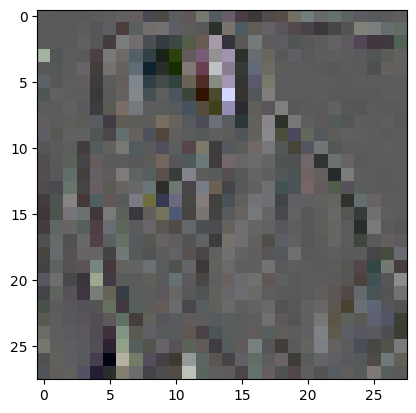

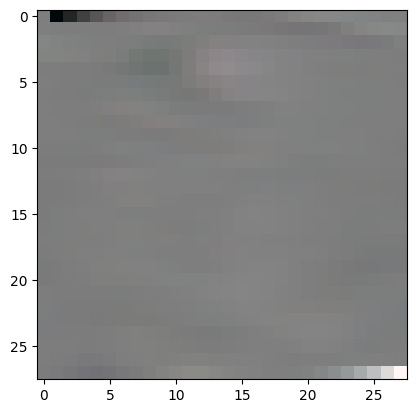

1049087967232.0


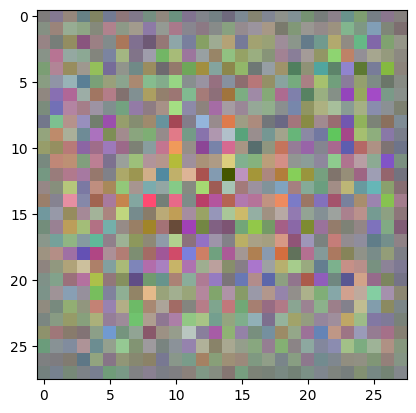

 33%|███▎      | 1/3 [00:01<00:03,  1.84s/it]

[-5.14810346e+00 -5.15351036e+00 -5.16340060e+00 ...  1.20857985e-05
  2.91825509e-05  1.02767899e-06]
[-5.27213354e+00 -5.29021596e+00 -5.25569752e+00 ...  1.95288976e-08
  2.23950810e-05  5.44615068e-06]
[-5.19288834e+00 -5.16232007e+00 -5.21758148e+00 ...  1.72002747e-05
  2.73099668e-05  1.80084298e-05]
time:  0.13400626182556152


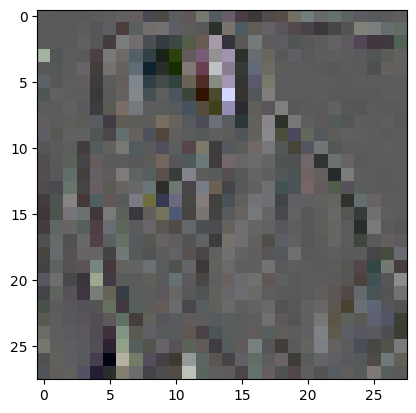

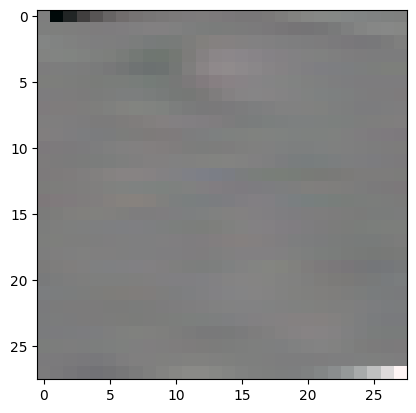

5852603351040.0


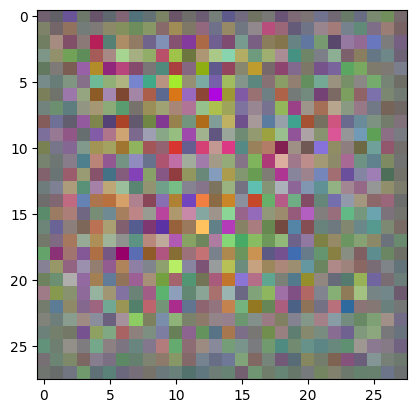

 67%|██████▋   | 2/3 [00:02<00:01,  1.05s/it]

[-5.27213516e+00 -5.28755307e+00 -5.31321718e+00 ...  1.75629102e-05
  2.28222671e-05  5.29631870e-05]
[-5.19431819e+00 -5.20083493e+00 -5.16912057e+00 ...  2.37863260e-05
  9.93995945e-06  9.94174297e-06]
[-5.14208070e+00 -5.15009645e+00 -5.14920877e+00 ...  8.01467013e-06
  1.05151457e-06  3.12261072e-05]
time:  0.14479827880859375


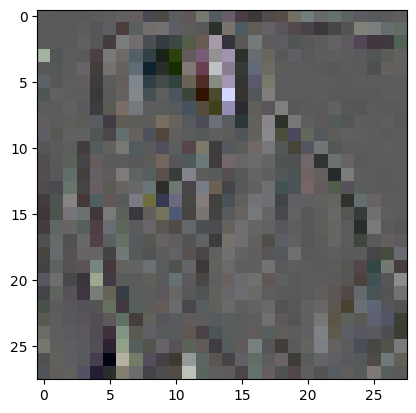

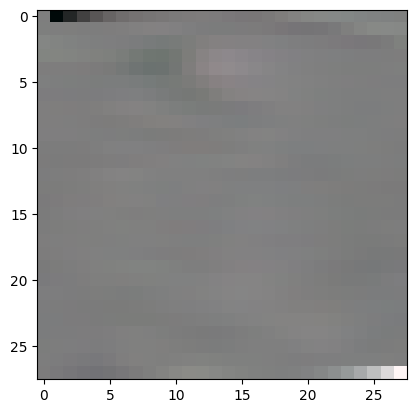

1705358393344.0


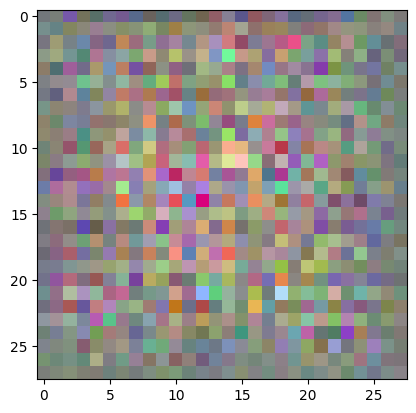

100%|██████████| 3/3 [00:02<00:00,  1.07it/s]


model has been saved


In [17]:

threads = [None] * channels
loss_c_hist = []
loss_hist = []

for e in tqdm(range(epochs)):
  x = torch.zeros((channels, N, H, W))
  m = np.zeros((channels, N, H*W), dtype=np.float32)
  del_m = np.zeros_like(m, dtype=np.float32)
  # we want to sample from random time steps to construct training samples
  random_t = np.linspace([dt + eps] * n_data, [1] * n_data, N-1, axis=1)
  random_t += np.random.uniform(-dt/2, dt/2, random_t.shape)
  random_t[:, -1] = 1
  time_ = np.sort(np.insert(random_t, 0, eps, axis=1), axis=1).astype(np.float32)
  sigma_ = diffusion_coeff(torch.tensor(time_), sigma).detach().cpu().numpy()
  for idx, x_ in enumerate(dataset):
    data = x_
    train_x_data = torch.zeros((N, channels, H, W))
    train_y_data = torch.zeros_like(train_x_data)
    
    # diffuse all three channels concurrently
    start = time.time()
    for i in range(channels):
      threads[i] = threading.Thread(target=diffuse, args=[data, x, m, del_m, i, train_x_data, train_y_data, random_t[idx], time_[idx], sigma_[idx], idx])
      threads[i].start()
    for thread in threads:
      thread.join()
      
    print("time: ", time.time() - start)
    
    plt.imshow(np.clip((train_y_data[0] + abs(torch.min(train_y_data[0]))) / (torch.max(train_y_data[0]) + abs(torch.min(train_y_data[0]))), 0, 1).reshape((channels, H, W)).moveaxis(0, 2))
    plt.show()
    plt.imshow(np.clip((train_y_data[-1] + abs(torch.min(train_y_data[-1]))) / (torch.max(train_y_data[-1]) + abs(torch.min(train_y_data[-1]))), 0, 1).reshape((channels, H, W)).moveaxis(0, 2))
    plt.show()

    y_pred = model_score(train_x_data, torch.tensor(time_[idx]))
    lm = (2*torch.tensor(sigma_[idx])**2)[:, None, None, None]
    loss = loss_fn(y_pred/lm, train_y_data)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses = loss.item()
    loss_hist.append(losses)
    print(losses)
    scores = (y_pred/lm).clone().detach().cpu().numpy().reshape((N, channels, H, W)) # we normalize before fedding back into PDE

    plt.imshow(np.moveaxis(np.clip((scores[0] + abs(np.min(scores[0]))) / (np.max(scores[0]) + abs(np.min(scores[0]))), 0, 1).reshape((channels, H, W)), 0, 2))
    plt.show()

torch.save(model_score.state_dict(), 'model_fdm.pth')
print(f"\nmodel has been saved")